# Goal of this analysis is to measure gene nuclear fraction per cell-type

In [1]:
import shapely
import geopandas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import math

import SRRS
from SRRS import plotting

In [2]:
gdf = geopandas.read_file('../../inputs/vz_Liver_nuclei.gpkg')
gdf

cell_id       area        sample  \
0        10538862489920183892740369332272690020  48.089404  Liver1Slice2   
1       119121808228938070631623775185479032904  14.497970  Liver1Slice2   
2       119121808228938070631623775185479032904   2.910091  Liver1Slice2   
3       126432960480588954615687533268541756376  34.448716  Liver1Slice2   
4       330594197380057235309893434432323108852  47.675343  Liver1Slice2   
...                                         ...        ...           ...   
240345   34503263976804858829294532944856557993   4.490560  Liver2Slice2   
240346   50964793435670335808821289274915410024   1.842879  Liver2Slice2   
240347  225492492141914068199922541095653139650   1.912862  Liver2Slice2   
240348  329777031946884498576271084456653585882  82.422188  Liver2Slice2   
240349   71548011046969829299018518480179924993   2.280271  Liver2Slice2   

               z          fov  \
0       zIndex_6   hdf5_fov10   
1       zIndex_6   hdf5_fov10   
2       zIndex_6   hdf5_fov10   
3       zIndex_6   hdf5_fov10   
4       zIndex_6   hdf5_fov10   
...          ...          ...   
240345  zIndex_2  hdf5_fov998   
240346  zIndex_2  hdf5_fov998   
240347  zIndex_2  hdf5_fov999   
240348  zIndex_2  hdf5_fov999   
240349  zIndex_2  hdf5_fov999   

                                                 geometry  
0       POLYGON ((4197.727 5691.211, 4195.783 5688.295...  
1       POLYGON ((4187.791 5788.194, 4188.763 5787.654...  
2       POLYGON ((4195.783 5788.194, 4192.867 5787.114...  
3       POLYGON ((4061.433 5613.344, 4060.785 5612.588...  
4       POLYGON ((4140.056 5706.439, 4139.408 5703.955...  
...                                                   ...  
240345  POLYGON ((5790.398 7532.895, 5790.182 7531.923...  
240346  POLYGON ((5690.607 7473.927, 5689.959 7472.955...  
240347  POLYGON ((5680.694 7627.999, 5680.262 7627.027...  
240348  POLYGON ((5780.917 7604.024, 5778.433 7601.216...  
240349  POLYGON ((5792.797 7632.211, 5791.933 7632.427...  

[240350 rows x 6 columns]

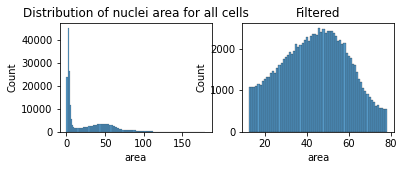

Num nuclei before filtering by area 240350
Num nuclei after filtering by area 108060


In [3]:
#Filter out nuclei that are too small or too large (causes around half of the "nuclei" to be removed)
fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(6,2))

min_um2_area = 2*2*math.pi #2 um radius
max_um2_area = 5*5*math.pi #5 um radius

sns.histplot(
    x = 'area',
    data = gdf,
    ax = axs[0],
)
axs[0].set_title('Distribution of nuclei area for all cells')

sns.histplot(
    x = 'area',
    data = gdf[gdf['area'].between(min_um2_area,max_um2_area)],
    ax = axs[1],
)
axs[1].set_title('Filtered')
plt.show()
plt.close()

print('Num nuclei before filtering by area',len(gdf))
filt_gdf = gdf[gdf['area'].between(min_um2_area,max_um2_area)]
print('Num nuclei after filtering by area',len(filt_gdf))

In [4]:
#Only keep cells that have at least two z-slices with nuclei
#Leaves us with ~26,000 unique cells
zslice_nucs_per_cell = filt_gdf.groupby('cell_id')['z'].transform('nunique')
filt_gdf = filt_gdf[zslice_nucs_per_cell >= 2]
filt_gdf['cell_id'].nunique()

26163

In [5]:
filt_gdf[filt_gdf['cell_id'].eq('298485487856188441331466795384118399264')]

cell_id       area        sample  \
112388  298485487856188441331466795384118399264  73.143242  Liver1Slice1   
123880  298485487856188441331466795384118399264  20.417357  Liver1Slice1   
135076  298485487856188441331466795384118399264  71.387851  Liver1Slice1   
148309  298485487856188441331466795384118399264  53.530682  Liver1Slice1   
159335  298485487856188441331466795384118399264  65.235234  Liver1Slice1   
175015  298485487856188441331466795384118399264  65.684288  Liver1Slice1   
185815  298485487856188441331466795384118399264  56.586579  Liver1Slice1   

               z           fov  \
112388  zIndex_3  hdf5_fov1004   
123880  zIndex_6  hdf5_fov1004   
135076  zIndex_2  hdf5_fov1004   
148309  zIndex_5  hdf5_fov1004   
159335  zIndex_1  hdf5_fov1004   
175015  zIndex_4  hdf5_fov1004   
185815  zIndex_0  hdf5_fov1004   

                                                 geometry  
112388  POLYGON ((2381.414 230.172, 2379.579 226.392, ...  
123880  POLYGON ((2378.823 229.092, 2376.123 226.392, ...  
135076  POLYGON ((2380.875 230.820, 2380.335 229.308, ...  
148309  POLYGON ((2380.119 228.336, 2379.687 227.256, ...  
159335  POLYGON ((2380.767 230.496, 2380.335 229.524, ...  
175015  POLYGON ((2381.306 229.416, 2379.903 226.824, ...  
185815  POLYGON ((2379.903 231.252, 2379.903 230.280, ...

In [6]:
%%time
#Load the cells which have nuclei in them (slow)
vz_liver_hdf5_paths = {
    'Liver1Slice1':'../../inputs/Liver1Slice1.hdf5',
    'Liver1Slice2':'../../inputs/Liver1Slice2.hdf5',
    'Liver2Slice1':'../../inputs/Liver2Slice1.hdf5',
    'Liver2Slice2':'../../inputs/Liver2Slice2.hdf5',
}

cells = []
for s,g in filt_gdf.groupby('sample'):
    print(s,len(cells))
    cell_ids = g['cell_id'].unique()
    sample = SRRS.HDF5(vz_liver_hdf5_paths[s])
    cells.extend(sample.get_cells_by_id(cell_ids, ignore_missing=True))


Liver1Slice1 0
Liver1Slice2 9221
Liver2Slice1 12885
Liver2Slice2 19809
CPU times: user 7min 33s, sys: 14.7 s, total: 7min 48s
Wall time: 1h 17min 50s


In [7]:
print('Number of cells read from the hdf5 file',len(cells))

Number of cells read from the hdf5 file 25855


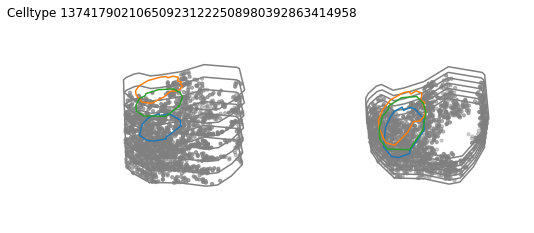

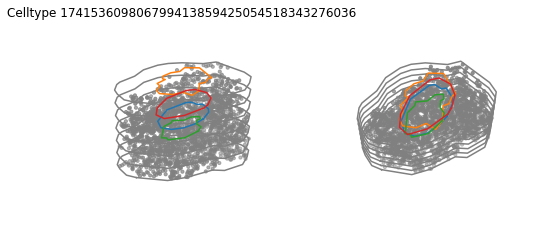

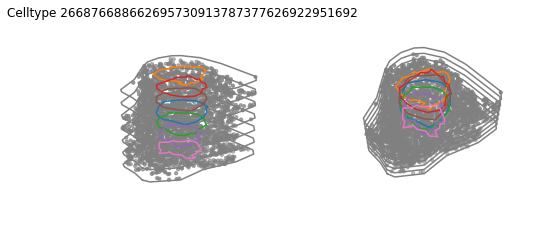

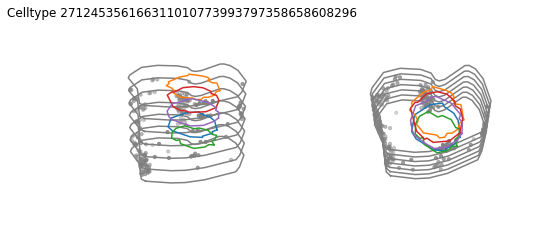

In [8]:
#Plotting where the nuclei boundaries are getting drawn in a handful of cells
#also saving to a pdf

num_plots = 5
filt_gdf['z_um'] = filt_gdf['z'].str.split('_').str[1].astype(int)*1.5 #convert z from ind to microns

pdf = matplotlib.backends.backend_pdf.PdfPages('nuclei_within_cell_plots.pdf')

for plot_num,cell in enumerate(cells):
    
    cell_id = cell.cell_id
    
    
    fig = plt.figure(figsize=plt.figaspect(0.5))
    
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    fig,ax1 = plotting.plot_cell_3D(cell, fig=fig, ax=ax1)
    
    for i,nuc_row in filt_gdf[filt_gdf['cell_id'].eq(cell_id)].iterrows():
        poly = nuc_row['geometry']
        xs,ys = poly.boundary.xy
        z_um = nuc_row['z_um']
        ax1.plot3D(xs, ys, z_um, zorder=10)
    
    ax1.elev = 30
    
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    fig,ax2 = plotting.plot_cell_3D(cell, fig=fig, ax=ax2)
    
    for i,nuc_row in filt_gdf[filt_gdf['cell_id'].eq(cell_id)].iterrows():
        poly = nuc_row['geometry']
        xs,ys = poly.boundary.xy
        z_um = nuc_row['z_um']
        ax2.plot3D(xs, ys, z_um, zorder=10)
    
    ax2.set_title('')
    ax2.elev = 70

    plt.show(fig)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()
    
    if plot_num >= num_plots-1:
        break
    
pdf.close()

In [9]:
filt_gdf.drop_duplicates('cell_id')['sample'].value_counts()

Liver1Slice1    9296
Liver2Slice1    7015
Liver2Slice2    6134
Liver1Slice2    3718
Name: sample, dtype: int64

In [10]:
#Count how many RNA spots of each gene are within or outside the nucleus boundary
#I haven't assigned cell-types to the vz_Livershowcase dataset yet
#but I can still count the fraction of spots of each gene within the nucleus for use later
gene_nuc_counts = {}

for num_cell,cell in enumerate(cells):
    if num_cell%100 == 0:
        print('Processing cell',num_cell+1,'of',len(cells))
    
    cell_id = cell.cell_id
    gene_nuc_counts[cell_id] = {}
    
    #Loop through the z_inds counting how many spots of each gene are within or outside the nucleus shape
    for i,nuc_row in filt_gdf[filt_gdf['cell_id'].eq(cell_id)].iterrows():
        nuc_poly = nuc_row['geometry']
        z_ind = nuc_row['z'][-1]
        
        #sometimes a z-slice might have been removed from the cell
        try:
            coords = cell.spot_coords[z_ind]
            genes = cell.spot_genes[z_ind]
            
        except KeyError:
            continue
        
        for (x,y),gene in zip(coords,genes):
            p = shapely.geometry.Point(x,y)
            
            if gene not in gene_nuc_counts[cell_id]:
                gene_nuc_counts[cell_id][gene] = {True:0, False:0}
        
            gene_nuc_counts[cell_id][gene][nuc_poly.contains(p)] += 1
            
gene_nuc_counts

Processing cell 1 of 25855
Processing cell 101 of 25855
Processing cell 201 of 25855
Processing cell 301 of 25855
Processing cell 401 of 25855
Processing cell 501 of 25855
Processing cell 601 of 25855
Processing cell 701 of 25855
Processing cell 801 of 25855
Processing cell 901 of 25855
Processing cell 1001 of 25855
Processing cell 1101 of 25855
Processing cell 1201 of 25855
Processing cell 1301 of 25855
Processing cell 1401 of 25855
Processing cell 1501 of 25855
Processing cell 1601 of 25855
Processing cell 1701 of 25855
Processing cell 1801 of 25855
Processing cell 1901 of 25855
Processing cell 2001 of 25855
Processing cell 2101 of 25855
Processing cell 2201 of 25855
Processing cell 2301 of 25855
Processing cell 2401 of 25855
Processing cell 2501 of 25855
Processing cell 2601 of 25855
Processing cell 2701 of 25855
Processing cell 2801 of 25855
Processing cell 2901 of 25855
Processing cell 3001 of 25855
Processing cell 3101 of 25855
Processing cell 3201 of 25855
Processing cell 3301 o

{'137417902106509231222508980392863414958': {'98': {True: 1, False: 1},
  '321': {True: 0, False: 1},
  '113': {True: 0, False: 1},
  '112': {True: 0, False: 1},
  '339': {True: 0, False: 1},
  '267': {True: 0, False: 1},
  '81': {True: 1, False: 1},
  '99': {True: 0, False: 3},
  '88': {True: 3, False: 0},
  '118': {True: 0, False: 1},
  '120': {True: 0, False: 1},
  '270': {True: 3, False: 12},
  '295': {True: 0, False: 1},
  '47': {True: 6, False: 20},
  '49': {True: 1, False: 1},
  '52': {True: 3, False: 2},
  '53': {True: 0, False: 4},
  '48': {True: 1, False: 5},
  '7': {True: 0, False: 3},
  '6': {True: 2, False: 1},
  '3': {True: 0, False: 4},
  '5': {True: 0, False: 3},
  '2': {True: 23, False: 56},
  '4': {True: 1, False: 1},
  '84': {True: 1, False: 6},
  '86': {True: 0, False: 1},
  '161': {True: 0, False: 1},
  '162': {True: 0, False: 1},
  '204': {True: 0, False: 1},
  '153': {True: 0, False: 1},
  '155': {True: 0, False: 1},
  '163': {True: 0, False: 1},
  '141': {True: 

In [11]:
data = {
    'cell_id':[],
    'gene_id':[],
    'num_within':[],
    'num_outside':[],
}

for cell_id in gene_nuc_counts:
    for gene_id in gene_nuc_counts[cell_id]:
        data['cell_id'].append(cell_id)
        data['gene_id'].append(gene_id)
        data['num_within'].append(gene_nuc_counts[cell_id][gene_id][True])
        data['num_outside'].append(gene_nuc_counts[cell_id][gene_id][False])
        
count_df = pd.DataFrame(data)
count_df.head()

cell_id gene_id  num_within  num_outside
0  137417902106509231222508980392863414958      98           1            1
1  137417902106509231222508980392863414958     321           0            1
2  137417902106509231222508980392863414958     113           0            1
3  137417902106509231222508980392863414958     112           0            1
4  137417902106509231222508980392863414958     339           0            1

In [12]:
count_df.shape

(3355712, 4)

In [13]:
count_df.to_csv('vz_Livershowcase_nuclear_gene_fractions.csv', index=False)

In [14]:
count_df[count_df['num_within'] > count_df['num_outside'] + 10]

cell_id gene_id  num_within  \
4377     274874777373505386742684298628412025693     270          14   
4612      70072655823015327943401167575869520749      24          38   
4646      70072655823015327943401167575869520749       8          27   
13917     78043268597369154250627644677212268858     164          31   
18491    156216474971078290137593239020247841522     223          21   
...                                          ...     ...         ...   
3280590  152349763150819197032383893127294884153       8          33   
3283209  322859842210377972068765312958002854782      18          14   
3285395  301470742223100598233501759014031232724       8          17   
3289083  134211040171958043815655643121087783322       8          13   
3348885  145805329071064986509577722921385159319      18          16   

         num_outside  
4377               3  
4612              25  
4646              14  
13917             15  
18491              2  
...              ...  
3280590           20  
3283209            1  
3285395            4  
3289083            1  
3348885            4  

[760 rows x 4 columns]